In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import notebook
import sys
from icecube import astro
sys.path.append('/home/apizzuto/Nova/scripts/')
from Novae import Nova
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import *

import matplotlib as mpl
plt.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')

## First, recreate ORCA limits

The goal is to reproduce the limits from the ORCA ICRC proceedings. They quote a sensitivity on the "neutrino fluence" of $3\times 10^5$ GeV cm$^{-2}$ for 3 events with effective areas provided. Using $$N_{\nu} = \int dE A_{eff} \phi $$ we can calculate the normalization $\phi_0$ if $\phi = \phi_0 \Big( \frac{E}{E_0} \Big)^{-2}$

We begin by reading in effective areas

In [3]:
orca = {}
for flav in ['numu', 'numubar', 'nue', 'nuebar']:
    orca[flav] = {}
    orca[flav]['A'] = pd.read_csv('/home/apizzuto/Nova/data/orca_115_{}.csv'.format(flav), header=0, names = ['Energy', 'Aeff'])
    orca[flav]['logspline'] = sp.interpolate.UnivariateSpline(np.log10(orca[flav]['A']['Energy']), 
                                                              np.log10(orca[flav]['A']['Aeff']))

Plot effective areas and splines to show agreement

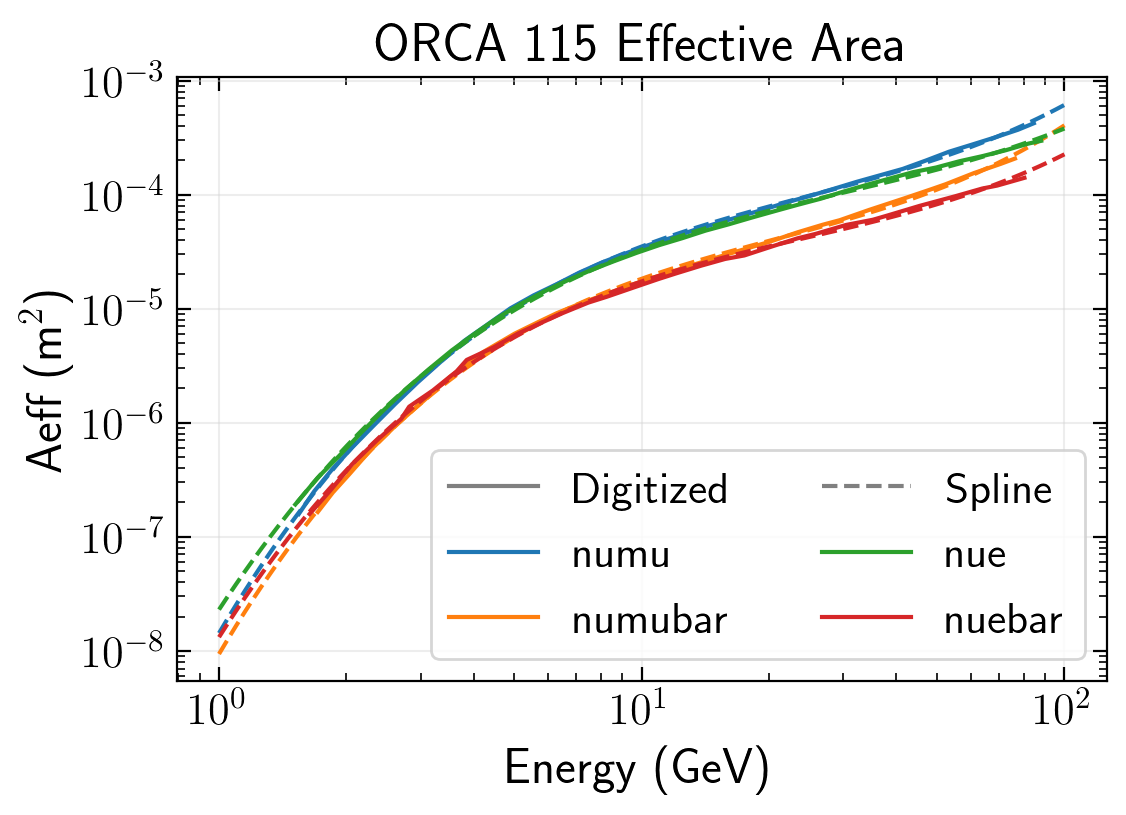

In [4]:
fig, ax = plt.subplots(dpi=200)

from matplotlib.lines import Line2D

for i, flav in enumerate(['numu', 'numubar', 'nue', 'nuebar']):
    plt.plot(orca[flav]['A']['Energy'], orca[flav]['A']['Aeff'], label = flav, 
                color = mpl.rcParams['axes.prop_cycle'].by_key()['color'][i])
    logens = np.linspace(0., 2., 100)
    ens = np.power(10., logens)
    plt.plot(ens, np.power(10., orca[flav]['logspline'](np.linspace(0., 2., 100))), ls = '--',
                            color = mpl.rcParams['axes.prop_cycle'].by_key()['color'][i])

handles, labels = ax.get_legend_handles_labels()
handles.insert(0, Line2D([0], [0], color='gray', ls='-', label = 'Digitized'))
handles.insert(3, Line2D([0], [0], color='gray', ls='--', label = 'Spline'))
    
plt.title('ORCA 115 Effective Area')
plt.legend(handles = handles, loc=4, ncol = 2)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'Aeff (m$^2$)')
plt.loglog()
plt.show()

## Now, multiply by a flux and integrate

In [5]:
def flux(en, E_0 = 1., phi_0 = 1.0, gamma = 2.0):
    return phi_0 * np.power(en/E_0, gamma*-1.)

def eff_A(flav, en):
    #remember to convert m^2 to cm^2
    return 1e4*np.power(10., orca[flav]['logspline'](np.log10(en)))

def dnde(en, flav, E_0 = 1., phi_0 = 1.0, gamma = 2.0):
    return eff_A(flav, en) * flux(en, E_0 = E_0, phi_0 = phi_0, gamma = gamma)

def num_evs(flav):
    return sp.integrate.quad(dnde, 1., 100., args=(flav))

__Caveats__: 
* I am interpreting "neutrino fluence" as $E^2 dN/dEdt \Delta T$
* I am treating their result as an all flavor (nu + nubar) sum on the fluence, not per flavor

In [6]:
flavs = ['numu', 'numubar', 'nue', 'nuebar']
phi_0 = 3. / np.sum([num_evs(flav) for flav in flavs]) * len(flavs)
print('ORCA results\n' + '-'*50)
print('Normalization in units of GeV cm^-2: {:.2e}'.format(phi_0))
print('Normalization in units of GeV m^-2: {:.2e}'.format(phi_0*1e4))

ORCA results
--------------------------------------------------
Normalization in units of GeV cm^-2: 3.34e+01
Normalization in units of GeV m^-2: 3.34e+05


## Time for IceCube

In [43]:
delta_cos_theta = 0.2
zenith = np.deg2rad(-23.)

def mids(arr):
    return arr[:-1] + (np.diff(arr) / 2.)

def initialize_mc(mc, zenith = np.deg2rad(23.), delta_cos_theta=0.2):
    zen_msk = np.cos(mc['zen']) > np.cos(zenith) - (delta_cos_theta/2.)
    zen_msk *= np.cos(mc['zen']) < np.cos(zenith) + (delta_cos_theta/2.)
    return mc[zen_msk]

def initialize_aeff(mc, delta_cos_theta=0.2):
    r'''
    Calculates effective area from Monte-Carlo events with weights
    '''
    d_omega = 2. * np.pi * delta_cos_theta
    if np.max(mc['trueE']) < 1e3:
        E_bins = np.logspace(0., 3., 61)
    else:
        E_bins = np.logspace(0., 9., 61)
    logE_bins = np.log10(E_bins)
    dlog_E = np.diff(logE_bins)
    weights = mc['ow'] / (1e4 * mc['trueE'] * dlog_E[np.digitize(np.log10(mc['trueE']), bins = logE_bins) -1] * d_omega * np.log(10.))
    h, b = np.histogram(mc['trueE'], weights = weights, bins = E_bins)
    aeff_dict = {'bins': b, 'vals': h}
    return aeff_dict

def aeff(en, aeff_dict):
    r'''
    Parameters:
    -----------
    en (float or array-like)
        Energy at which you wish to evaluate effective area
    Returns:
    --------
    aeff (float or array-like) 
        effective area in units of cm^2
    '''
    bin_centers = mids(aeff_dict['bins'])
    aeffs = np.interp(en, bin_centers, aeff_dict['vals'])
    return 1e4*aeffs


In [38]:
from glob import glob
mcs = glob('/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/IC86_2012.nu*_with_angErr.npy')
mc = np.load(mcs[0])
for ind in [1,2]:
    mc = np.append(mc, np.load(mcs[ind]))

grecomc = {}
grecomc['numu'] = initialize_mc(mc[mc['ptype'] == 14.])
grecomc['numubar'] = initialize_mc(mc[mc['ptype'] == -14.])
grecomc['nue'] = initialize_mc(mc[mc['ptype'] == 12.])
grecomc['nuebar'] = initialize_mc(mc[mc['ptype'] == -12.])
grecomc['nutau'] = initialize_mc(mc[mc['ptype'] == 16.])
grecomc['nutaubar'] = initialize_mc(mc[mc['ptype'] == -16.])

In [39]:
greco = {}
for flav in ['numu', 'numubar', 'nue', 'nuebar', 'nutau', 'nutaubar']:
    greco[flav] = {}
    greco[flav]['aeff_dict'] = initialize_aeff(grecomc[flav])
    
def greco_aeff(ens, flav):
    return aeff(ens, greco[flav]['aeff_dict'])

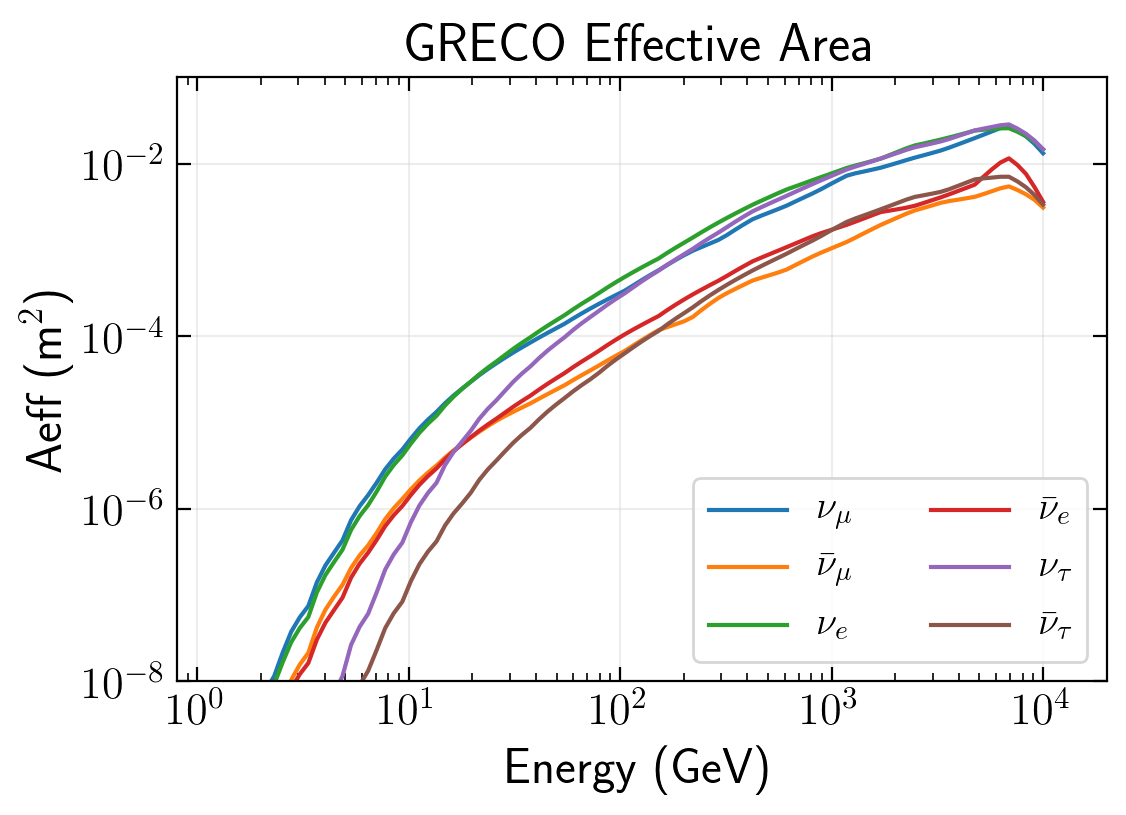

In [40]:
fig, ax = plt.subplots(dpi=200)

#for i, flav in enumerate(['numu', 'numubar', 'nue', 'nuebar']):
#    plt.plot(orca[flav]['A']['Energy'], orca[flav]['A']['Aeff'], label = '',
#                color = mpl.rcParams['axes.prop_cycle'].by_key()['color'][i], alpha = 0.45)

ens = np.logspace(0., 4., 100)
plt.plot(ens, greco_aeff(ens, 'numu')/1e4, label = r'$\nu_{\mu}$')
plt.plot(ens, greco_aeff(ens, 'numubar')/1e4, label = r'$\bar{\nu}_{\mu}$')
plt.plot(ens, greco_aeff(ens, 'nue')/1e4, label = r'$\nu_{e}$')
plt.plot(ens, greco_aeff(ens, 'nuebar')/1e4, label = r'$\bar{\nu}_{e}$')
plt.plot(ens, greco_aeff(ens, 'nutau')/1e4, label = r'$\nu_{\tau}$')
plt.plot(ens, greco_aeff(ens, 'nutaubar')/1e4, label = r'$\bar{\nu}_{\tau}$')

plt.title('GRECO Effective Area')
plt.legend(loc=4, ncol = 2, fontsize = 14)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'Aeff (m$^2$)')
plt.loglog()
plt.ylim(1e-8, 1e-1)
plt.xlim(8e-1, 2e4)
plt.show()

In [42]:
def centers(arr):
    return arr[:-1] + np.diff(arr) / 2.

In [52]:
from glob import glob
mcs = glob('/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/IC86_2012.nu*_with_angErr.npy')
mc = np.load(mcs[0])
for ind in [1,2]:
    mc = np.append(mc, np.load(mcs[ind]))

    
cos_thetas = np.linspace(-1., 1., 13)
delta_cos_theta = np.mean(np.diff(cos_thetas))
zeniths = np.arccos(centers(cos_thetas))

out_dict = {}

for i, zenith in enumerate(zeniths):
    grecomc = {}
    grecomc['numu'] = initialize_mc(mc[mc['ptype'] == 14.], zenith=zenith, delta_cos_theta=delta_cos_theta)
    grecomc['numubar'] = initialize_mc(mc[mc['ptype'] == -14.], zenith=zenith, delta_cos_theta=delta_cos_theta)
    grecomc['nue'] = initialize_mc(mc[mc['ptype'] == 12.], zenith=zenith, delta_cos_theta=delta_cos_theta)
    grecomc['nuebar'] = initialize_mc(mc[mc['ptype'] == -12.], zenith=zenith, delta_cos_theta=delta_cos_theta)
    grecomc['nutau'] = initialize_mc(mc[mc['ptype'] == 16.], zenith=zenith, delta_cos_theta=delta_cos_theta)
    grecomc['nutaubar'] = initialize_mc(mc[mc['ptype'] == -16.], zenith=zenith, delta_cos_theta=delta_cos_theta)
    
    
    greco = {}
    for flav in ['numu', 'numubar', 'nue', 'nuebar', 'nutau', 'nutaubar']:
        greco[flav] = {}
        greco[flav]['aeff_dict'] = initialize_aeff(grecomc[flav])

    def greco_aeff(ens, flav):
        return aeff(ens, greco[flav]['aeff_dict'])
    
    ens = np.logspace(0., 4., 100)
    #plt.plot(ens, greco_aeff(ens, 'numu')/1e4, label = r'$\nu_{\mu}$')
    #plt.plot(ens, greco_aeff(ens, 'numubar')/1e4, label = r'$\bar{\nu}_{\mu}$')
    #plt.plot(ens, greco_aeff(ens, 'nue')/1e4, label = r'$\nu_{e}$')
    #plt.plot(ens, greco_aeff(ens, 'nuebar')/1e4, label = r'$\bar{\nu}_{e}$')
    #plt.plot(ens, greco_aeff(ens, 'nutau')/1e4, label = r'$\nu_{\tau}$')
    #plt.plot(ens, greco_aeff(ens, 'nutaubar')/1e4, label = r'$\bar{\nu}_{\tau}$')

    #plt.title(r'GRECO Effective Area, $\cos\theta = $' + '{:.2e}'.format(np.cos(zenith)))
    #plt.legend(loc=4, ncol = 2, fontsize = 14)
    #plt.xlabel('Energy (GeV)')
    #plt.ylabel(r'Aeff (m$^2$)')
    #plt.loglog()
    #plt.ylim(1e-8, 1e-1)
    #plt.xlim(8e-1, 2e4)
    #plt.show()

    out_dict['cos_theta_{:.2f}_{:.2f}'.format(cos_thetas[i], cos_thetas[i+1])] = {'Energy (GeV)': list(ens), 
                      'numu': list(greco_aeff(ens, 'numu')/1e4), 
                      'numubar': list(greco_aeff(ens, 'numubar')/1e4), 
                      'nue': list(greco_aeff(ens, 'nue')/1e4), 
                      'nuebar': list(greco_aeff(ens, 'nuebar')/1e4),
                      'nutau': list(greco_aeff(ens, 'nutau')/1e4), 
                      'nutaubar': list(greco_aeff(ens, 'nutaubar')/1e4)}

    

In [54]:
import json

with open('/home/apizzuto/public_html/novae/effective_areas_Ali.txt', 'w') as f:
     f.write(json.dumps(out_dict)) 

In [11]:
def ic_dnde(en, flav, E_0 = 1., phi_0 = 1.0, gamma = 2.0):
    return greco_aeff(en, flav) * flux(en, E_0 = E_0, phi_0 = phi_0, gamma = gamma)

def ic_num_evs(flav, lowen = 1., highen = 100.):
    return sp.integrate.quad(ic_dnde, lowen, highen, args=(flav))

In [12]:
flavs_ops = [['numu', 'numubar', 'nue', 'nuebar'], 
             ['numu', 'numubar', 'nue', 'nuebar', 'nutau', 'nutaubar']]
en_ops = [(1., 100.), (1., 1000.)]

for flavs in flavs_ops:
    for low_en, high_en in en_ops:
        phi_0 = 2.5 / np.sum([ic_num_evs(flav, lowen=low_en, highen=high_en) for flav in flavs]) * 4
        print('GRECO results for {} flavors, high energy {} GeV\n'.format(len(flavs), high_en) + '-'*50)
        print('Normalization in units of GeV cm^-2: {:.2e}'.format(phi_0))
        print('Normalization in units of GeV m^-2: {:.2e}'.format(phi_0*1e4))
        print('\n\n')

/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """


GRECO results for 4 flavors, high energy 100.0 GeV
--------------------------------------------------
Normalization in units of GeV cm^-2: 6.81e+01
Normalization in units of GeV m^-2: 6.81e+05



GRECO results for 4 flavors, high energy 1000.0 GeV
--------------------------------------------------
Normalization in units of GeV cm^-2: 1.60e+01
Normalization in units of GeV m^-2: 1.60e+05



GRECO results for 6 flavors, high energy 100.0 GeV
--------------------------------------------------
Normalization in units of GeV cm^-2: 5.76e+01
Normalization in units of GeV m^-2: 5.76e+05



GRECO results for 6 flavors, high energy 1000.0 GeV
--------------------------------------------------
Normalization in units of GeV cm^-2: 1.20e+01
Normalization in units of GeV m^-2: 1.20e+05





In [13]:
evs = np.load('/home/mlarson/GRECO/version-001-p00/IC86_2015_data.npy')
grl = np.load('/home/mlarson/GRECO/version-001-p00/GRL/IC86_2015_data.npy')
print 'Rate (Hz) :{}'.format(np.sum(grl['events']) / (np.sum(grl['livetime']) * 86400.))

Rate (Hz) :0.00145878321143


## For the $E_{iso}$ plot, just scale the ORCA results by relevant flux ratios

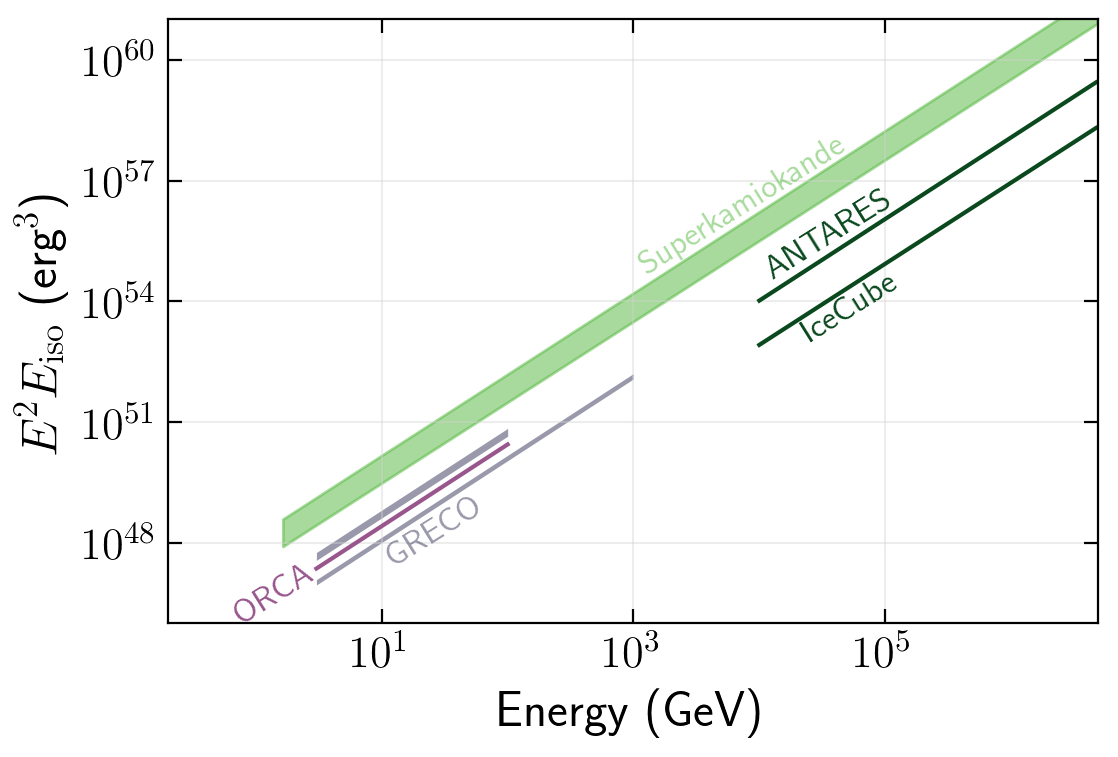

In [14]:
Eiso = {}
Eiso['ORCA'] = [[3.0229227306885886, 100.41055311972177], [2.308525330626382e+47, 2.792238794875461e+50]]
Eiso['SuperKlow'] = [[1.635020234312159,4902204.89263653], [8.155925897421513e+47, 7.787132076035585e+60]]
Eiso['SuperKhigh'] = [[1.635020234312159,4902204.89263653], [3.896893655571058e+48, 4.3177281720699434e+61]]
Eiso['IceCube'] = [[10082.279177808445, 4802801.768974906], [8.262721163137414e+52, 2.0124213176328351e+58]]
Eiso['ANTARES'] = [[10082.279177808445, 4802801.768974906], [1.0395695625734725e+54, 2.72768603895957e+59]]
Eiso['GRECO'] = [[3.0229227306885886, 1000.], [2.308525330626382e+47, 3e52]]

fig, ax = plt.subplots(dpi=200)

plt.plot(Eiso['ORCA'][0], Eiso['ORCA'][1], color = sns.xkcd_rgb['purpleish'], label = 'ORCA')
plt.text(6e-1, 1e47, 'ORCA', rotation=32, color = sns.xkcd_rgb['purpleish'], fontsize = 12)

plt.fill_between(Eiso['ORCA'][0], np.array(Eiso['ORCA'][1])*1.6, np.array(Eiso['ORCA'][1])*2.5, 
                color = sns.xkcd_rgb['dark navy blue'], alpha = 0.4, lw=0.001)
plt.fill_between(Eiso['GRECO'][0], np.array(Eiso['GRECO'][1])*0.39, np.array(Eiso['GRECO'][1])*0.53, 
                color = sns.xkcd_rgb['dark navy blue'], alpha = 0.4, lw = 0.001)
plt.text(1e1, 5e48, 'GRECO', rotation=32, color = sns.xkcd_rgb['dark navy blue'], 
         alpha = 0.4, fontsize = 12)


plt.fill_between(Eiso['SuperKlow'][0], Eiso['SuperKlow'][1], Eiso['SuperKhigh'][1],
                    alpha = 0.5, color = sns.xkcd_rgb['leafy green'], label = 'SuperK')
plt.text(1e3, 5e57, 'Superkamiokande', rotation=32, color = sns.xkcd_rgb['leafy green'], alpha = 0.5, fontsize = 12)

plt.plot(Eiso['IceCube'][0], Eiso['IceCube'][1], label = 'IceCube', color = sns.xkcd_rgb['pine green'])
plt.text(2e4, 2e54, 'IceCube', rotation=32, color = sns.xkcd_rgb['pine green'], fontsize=12)

plt.plot(Eiso['ANTARES'][0], Eiso['ANTARES'][1], label = 'ANTARES', color = sns.xkcd_rgb['pine green'])
plt.text(1e4, 2e56, 'ANTARES', rotation=32, color = sns.xkcd_rgb['pine green'], fontsize=12)

#plt.legend(loc=2, ncol = 2, fontsize = 14)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 E_{\mathrm{iso}}$ (erg$^3$)')
plt.loglog()
plt.ylim(1e46, 1e61)
plt.xlim(2e-1, 5e6)
plt.show()

# Try with the other effective areas Michael has

In [57]:
greco_rt = {}
for flav in ['numu', 'numubar', 'nue', 'nuebar', 'nutau', 'nutaubar']:
    for channel in ['nc', 'cc']:
        greco_rt[flav+channel] = {}
        if channel == 'nc':
            if 'bar' in flav:
                truncflav = 'nubar'
            else:
                truncflav = 'nu'
            greco_rt[flav+channel]['A'] = pd.read_csv('/data/user/mlarson/combo_r129072/scripts/greco_online/plots_filtered/aeff_csv/greco_{}{}.csv'.format(truncflav, channel), header=0, names = ['Energy', 'Aeff'])
            greco_rt[flav+channel]['A']['Aeff'] *= (1./3.)
            greco_rt[flav+channel]['A'] = greco_rt[flav+channel]['A'][greco_rt[flav+channel]['A']['Aeff'] != 0]
            greco_rt[flav+channel]['logspline'] = sp.interpolate.UnivariateSpline(np.log10(greco_rt[flav+channel]['A']['Energy']), 
                                                                      np.log10(greco_rt[flav+channel]['A']['Aeff']))
        else: 
            greco_rt[flav+channel]['A'] = pd.read_csv('/data/user/mlarson/combo_r129072/scripts/greco_online/plots_filtered/aeff_csv/greco_{}{}.csv'.format(flav, channel), header=0, names = ['Energy', 'Aeff'])
            greco_rt[flav+channel]['A'] = greco_rt[flav+channel]['A'][greco_rt[flav+channel]['A']['Aeff'] != 0]
            greco_rt[flav+channel]['logspline'] = sp.interpolate.UnivariateSpline(np.log10(greco_rt[flav+channel]['A']['Energy']), 
                                                                      np.log10(greco_rt[flav+channel]['A']['Aeff']))

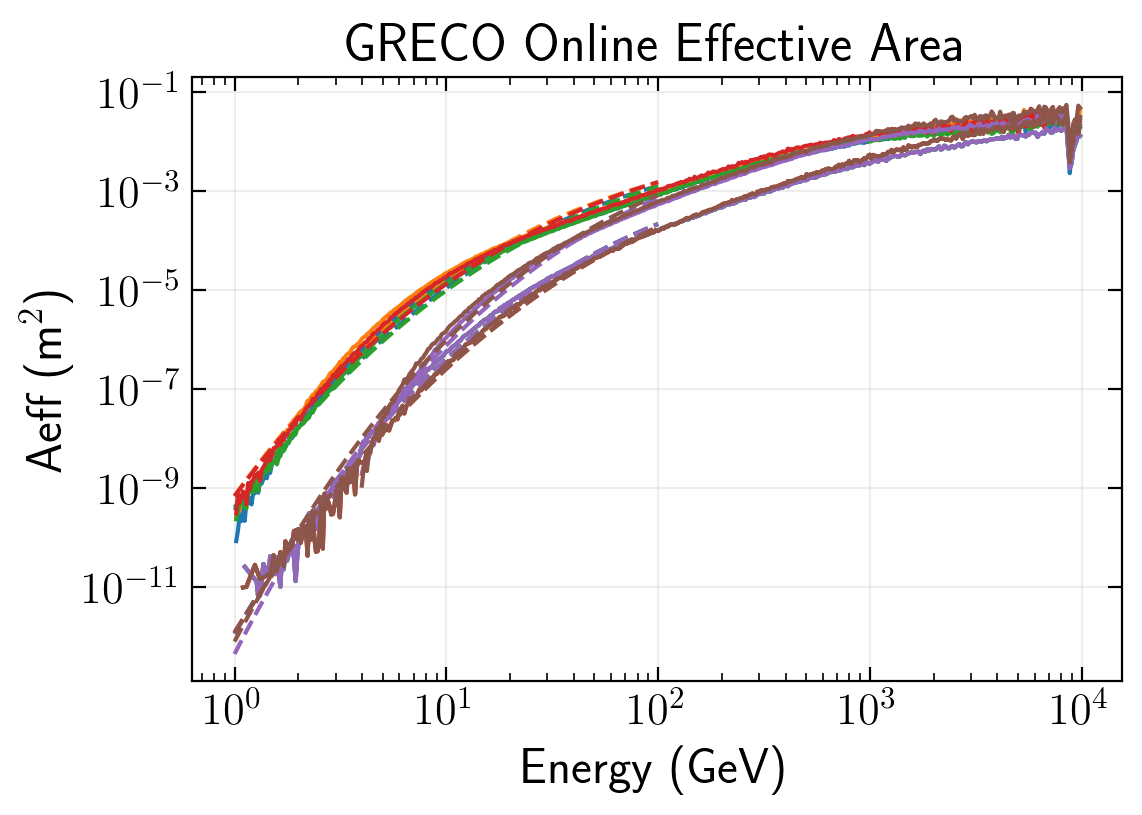

In [60]:
fig, ax = plt.subplots(dpi=200)

from matplotlib.lines import Line2D

for i, flav in enumerate(['numu', 'numubar', 'nue', 'nuebar', 'nutau', 'nutaubar']):
    for channel in ['nc', 'cc']:
        plt.plot(greco_rt[flav+channel]['A']['Energy'], greco_rt[flav+channel]['A']['Aeff'], label = flav+channel, 
                    color = mpl.rcParams['axes.prop_cycle'].by_key()['color'][i])
        logens = np.linspace(0., 2., 100)
        ens = np.power(10., logens)
        plt.plot(ens, np.power(10., greco_rt[flav+channel]['logspline'](np.linspace(0., 2., 100))), ls = '--',
                                color = mpl.rcParams['axes.prop_cycle'].by_key()['color'][i])

handles, labels = ax.get_legend_handles_labels()
handles.insert(0, Line2D([0], [0], color='gray', ls='-', label = 'Digitized'))
handles.insert(3, Line2D([0], [0], color='gray', ls='--', label = 'Spline'))
    
plt.title('GRECO Online Effective Area')
#plt.legend(handles = handles, loc=4, ncol = 2)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'Aeff (m$^2$)')
plt.loglog()
plt.show()